In [1]:
import arviz as az
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def readcdf(filename):
    return az.InferenceData.from_netcdf(filename)

In [3]:
az.style.use("arviz-darkgrid")

In [4]:
cyclerichmentffe_labels = ["cycle time / d", "fresh fuel enrichment / %", "product enrichment / %"]
cyclerichmentffe_names = ["cycle_time", "slight_enrichment_grade", "high_enrichment_grade"]

cyclerichment_labels = ["cycle time / d", "product enrichment / %"]
cyclerichment_names = ["cycle_time", "high_enrichment_grade"]

In [5]:
def plot_chain_hists(trace, figaxs=None):
    vars = list(trace.posterior.data_vars.keys())
    n = trace.posterior[vars[0]].shape[0]
    fig, axs = plt.subplots(trace.posterior[vars[0]].shape[0], len(vars), figsize=(len(vars)*5, n*4), tight_layout={'pad': 1.1})
    
    for i in range(0, n):
        for (j, v) in enumerate(vars):
            print(f'Iteration: plot {i}/{j} of {n*len(vars)}')
            ax = axs[i,j]
            ax.set_title(v)
            arr = trace.posterior[v][i].to_numpy()
            rmin, rmax = np.nanquantile(trace.posterior[v], [0.03, 0.97])
            ax.hist(arr[~(np.isnan(arr))], label=str(i), bins=25, range=(rmin, rmax))
    return fig

In [6]:
def plot_chains(trace, vars, xlims=None, ixs=None, labels=None, legends=None):
    n = trace.posterior[vars[0]].shape[0]
    fig, axs = plt.subplots(1, len(vars), figsize=(len(vars)*5, 4), tight_layout={'pad': 1.1})
    if ixs is None:
        ixs = range(0, n)
    if xlims:
        for i, (l, u) in enumerate(xlims):
            axs[i].set_xlim(l, u)
    if labels:
        for i, l in enumerate(labels):
            axs[i].set_xlabel(l)
            
    for (i, v) in enumerate(vars):
        for j, ix in enumerate(ixs):
            arr = trace.posterior[v][ix].to_numpy()
            sb.kdeplot(ax=axs[i], x=arr[~np.isnan(arr)], label=str(legends[j] if legends else ix))
            axs[i].legend()
    return fig

In [7]:
def prepare_df(jobid, df=None):
    if df is None:
        df = readcdf(f"data/merged_{jobid}.cdf").to_dataframe()
    renames = {c: c[1] for c in df.columns if type(c) is tuple and c[0] == 'posterior'}
    df.rename(columns=renames, inplace=True)
    return df

In [8]:
def plot_all_histograms(jobid):
    df = prepare_df(jobid)
    g = sb.PairGrid(data=df, vars=df.columns[2:], height=5)
    g.map_upper(sb.scatterplot)
    g.map_lower(sb.kdeplot)
    g.map_diag(sb.histplot)
    g.savefig(f'out/seaborn_all_hists_{jobid}.svg')

In [55]:
def individual_densities(jobid, varnames, xlabels=[], xlim=None, figaxs=None, name='', figsize=None, vert=False, log=False):
    df = prepare_df(jobid)

    if figsize is None:
        figsize = (len(varnames)*5, 4)
    if figaxs is None:
        if vert:
            dim1, dim2 = len(varnames), 1
            fs = tuple(reversed(figsize))
        else:
            dim1, dim2 = 1, len(varnames)
            fs = figsize
        fig, axs = plt.subplots(dim1, dim2, figsize=fs, squeeze=False)
    else:
        fig, axs = figaxs

    for (i, vn) in enumerate(varnames):
        ax = axs[i, 0] if vert else axs[0, i]
        sb.kdeplot(ax=ax, data=df, x=vn, label=name, log_scale=log)
        print('Lower 5%: ', np.quantile(df[vn], .05), 'Upper 95%: ', np.quantile(df[vn], .95))
        if xlim:
            ax.set_xlim(*xlim[i])
        if figaxs or name:
            ax.legend()
    if xlabels:
        [(axs[i, 0] if vert else axs[0,i]).set_xlabel(xl) for (i, xl) in enumerate(xlabels)]
    return fig, axs

In [ ]:
for jobid in [22663725]:
    plot_all_histograms(jobid)

## product enrichment only


Lower 5%:  82.57472341173428 Upper 95%:  94.00636365095004


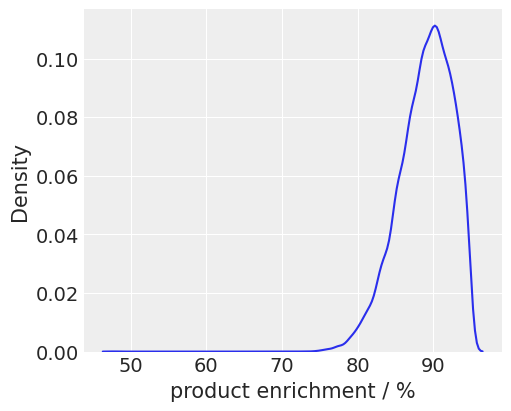

In [13]:
individual_densities(22815158, ["high_enrichment_grade"], ["product enrichment / %"])[0].savefig("out/prodenrich_density.svg")

In [531]:
df = prepare_df(22815158)
np.quantile(df.high_enrichment_grade, (1-.16)), np.quantile(df.high_enrichment_grade, .16)

(92.62437373814657, 85.40228208788211)

In [532]:
df.high_enrichment_grade.size

15000

In [525]:
plot_all_histograms(22815158)

/home/lbo/.anaconda3/envs/fcjupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.tight_layout(*args, **kwargs)


## cyclerichment

In [500]:
def kdeplot_2d_viridis(jobid):
    ax = sb.jointplot(data=prepare_df(jobid), x='cycle_time', y='high_enrichment_grade',
                      xlim=(55, 65), ylim=(75, 100), fill=True,
                      cmap='viridis', kind='kde')
    #ax.set_xlim(55,65)
    #ax.set_ylim(75,100)
    ax.ax_joint.set_ylabel('product enrichment / %')
    ax.ax_joint.set_xlabel('cycle time / d')
    return ax

In [535]:
kdeplot_2d_viridis(22629172)

/home/lbo/.anaconda3/envs/fcjupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


In [536]:
fig = kdeplot_2d_viridis(22815195)
fig.savefig('out/cyclerichment_kde.svg')

/home/lbo/.anaconda3/envs/fcjupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


In [540]:
df = prepare_df(22815195)
heg = df.high_enrichment_grade.to_numpy()
heg = heg[~np.isnan(heg)]
ct = df.cycle_time.to_numpy()
ct = ct[~np.isnan(ct)]
np.quantile(ct, (1-.16)), np.quantile(ct, .16), heg.size

(60.8787840109554, 60.13167867935392, 12800)

In [354]:
individual_densities(22629655, ["cycle_time"], ["cycle time / d"])[0].savefig("out/cycletime_densities.pdf")

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


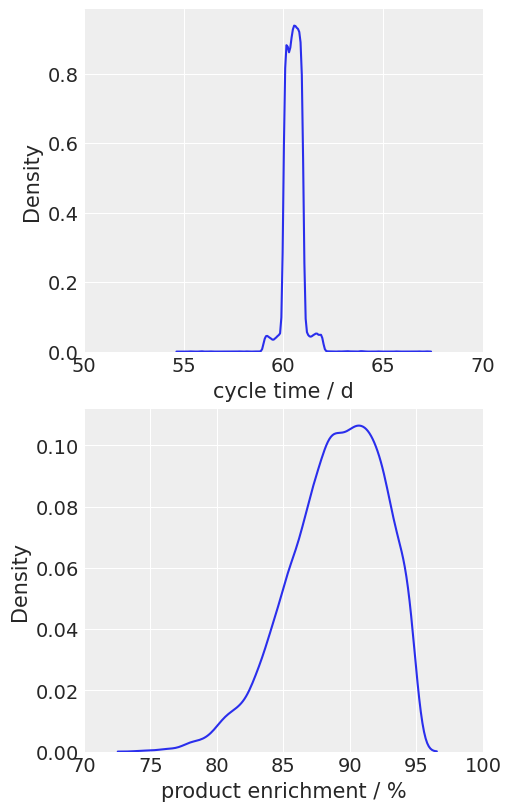

In [81]:
individual_densities(22815195, cyclerichment_names, cyclerichment_labels, vert=True, figsize=(8, 5), xlim=[(50, 70), (70, 100)])[0].savefig("out/cyclerichment_densities.pdf")

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


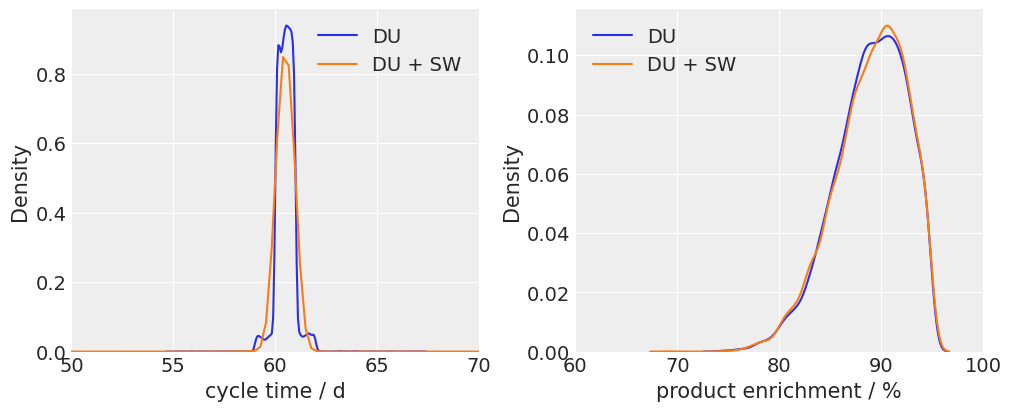

In [518]:
fa = None
fa = individual_densities(22815195, cyclerichment_names, cyclerichment_labels, name="DU", xlim=[(50, 70), (60, 100)])
fa = individual_densities(22629955, cyclerichment_names, cyclerichment_labels, name="DU + SW", figaxs=fa)
fa[0].savefig("out/cyclerichment_sepwaste.pdf")

## cyclerichment + fresh fuel

In [83]:
crf_reference_job = 22719870
individual_densities(crf_reference_job,  cyclerichmentffe_names, cyclerichmentffe_labels, xlim=[(35, 85), (1,2), (60, 100)])[0].savefig(f'out/cyclerichmentffe_{crf_reference_job}.pdf')

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


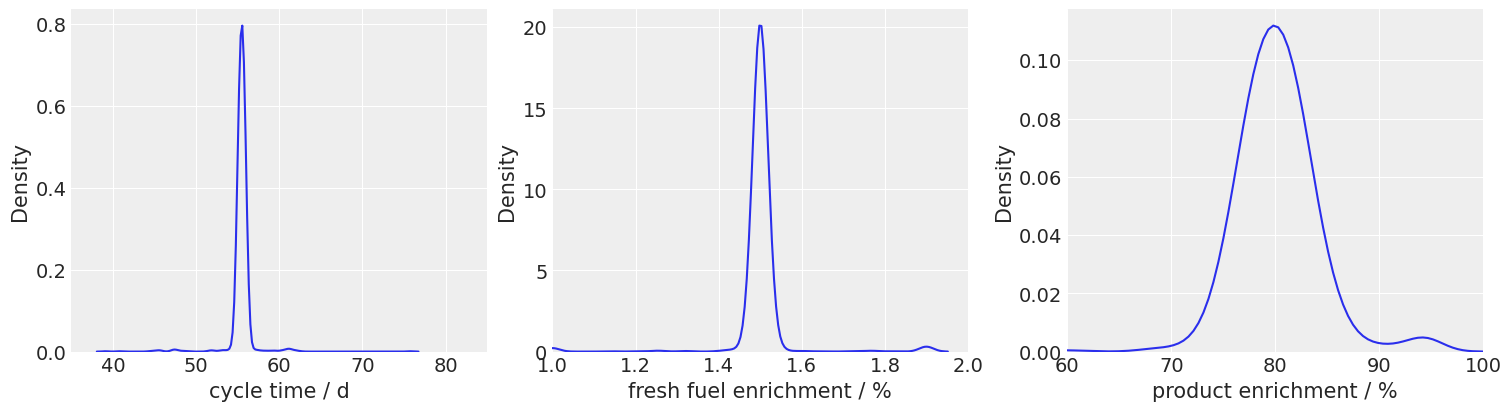

In [17]:
crf_cmp_job = 22674561
individual_densities(crf_cmp_job,  cyclerichmentffe_names, cyclerichmentffe_labels, xlim=[(35, 85), (1,2), (60, 100)])[0].savefig(f'out/cyclerichmentffe_{crf_cmp_job}.pdf')

In [18]:
priorsjob = 22711644
fa = individual_densities(priorsjob,  cyclerichmentffe_names, cyclerichmentffe_labels, name="normal prior")
fa = individual_densities(crf_reference_job,  cyclerichmentffe_names, cyclerichmentffe_labels, xlim=[(50, 70), (1,1.4), (65, 100)], name="uniform prior", figaxs=fa)[0].savefig(f'out/cyclerichmentffe_normprior_{priorsjob}.png')


Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


## uncertain priors

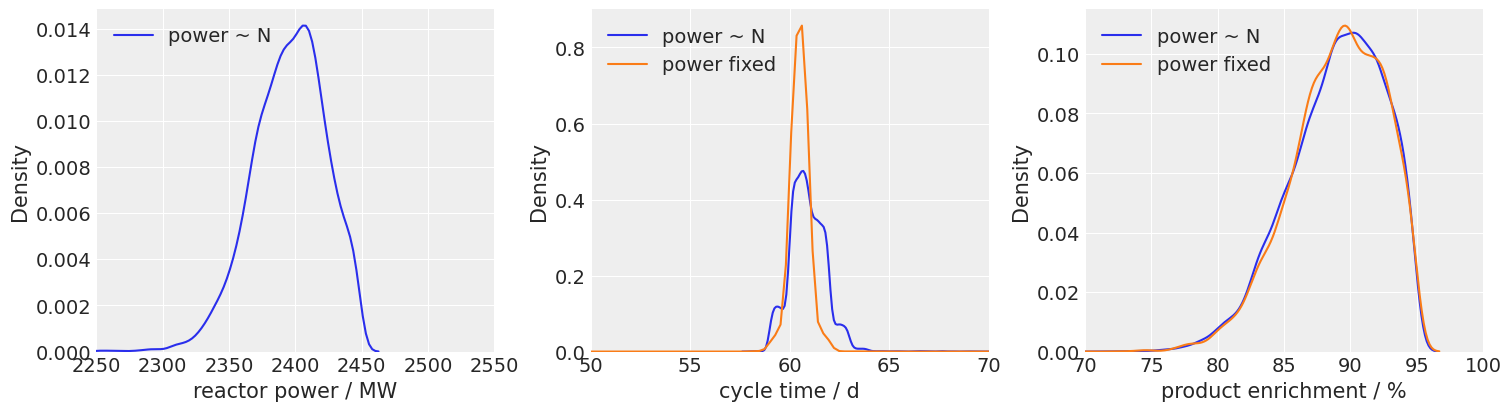

In [409]:
power_assumption_job = 22753252
fa = individual_densities(power_assumption_job,  ['power', 'cycle_time', 'high_enrichment_grade'], ['reactor power / MW', "cycle time / d", "product enrichment / %"], name='power ~ N', xlim=[(2250, 2550), (50, 70), (70, 100)])
individual_densities(22629172, cyclerichment_names, cyclerichment_labels, figsize=(8, 5), xlim=[(50, 70), (70, 100)], name='power fixed', figaxs=(fa[0], np.array([fa[1][0,1:]]).reshape(1, 2)))
fa[0].savefig(f'out/cyclerichment_power_{power_assumption_job}.pdf')

In [437]:
paj_trace = readcdf(f'data/merged_{power_assumption_job}.cdf')
clean = prepare_df(power_assumption_job, paj_trace.to_dataframe())['cycle_time']
clean = clean[clean.lt(65) & clean.gt(55)]

az.summary(paj_trace), clean.std()

(                           mean      sd    hdi_3%   hdi_97%  mcse_mean  \
 power                  2394.948  30.016  2349.982  2448.293      0.774   
 cycle_time               60.905   0.936    59.001    62.321      0.024   
 high_enrichment_grade    89.013   3.540    83.045    94.936      0.037   
 
                        mcse_sd  ess_bulk  ess_tail  r_hat  
 power                    0.549    1479.0    2238.0   1.01  
 cycle_time               0.017    1551.0    2529.0   1.01  
 high_enrichment_grade    0.026    8209.0    6389.0   1.00  ,
 0.8676018958051881)

In [438]:
ref_trace = prepare_df(22629172)
clean = ref_trace['cycle_time']
clean = clean[clean.lt(65) & clean.gt(55)]
clean.std()

0.4535012960166854

In [383]:
with pm.Model() as powermodel:
    ct = pm.Uniform("cycle_time", lower=20, upper=120)
    heg = pm.Uniform("high_enrichment_grade", lower=5, upper=95)
    power = pm.Normal("power", mu=2400, sigma=30)
    
powersamples = pm.sample_prior_predictive(35000, powermodel)

powerlabels = ['power / MW', 'cycle time / d', 'product enrichment / %']
powervars = ['power', 'cycle_time', 'high_enrichment_grade']

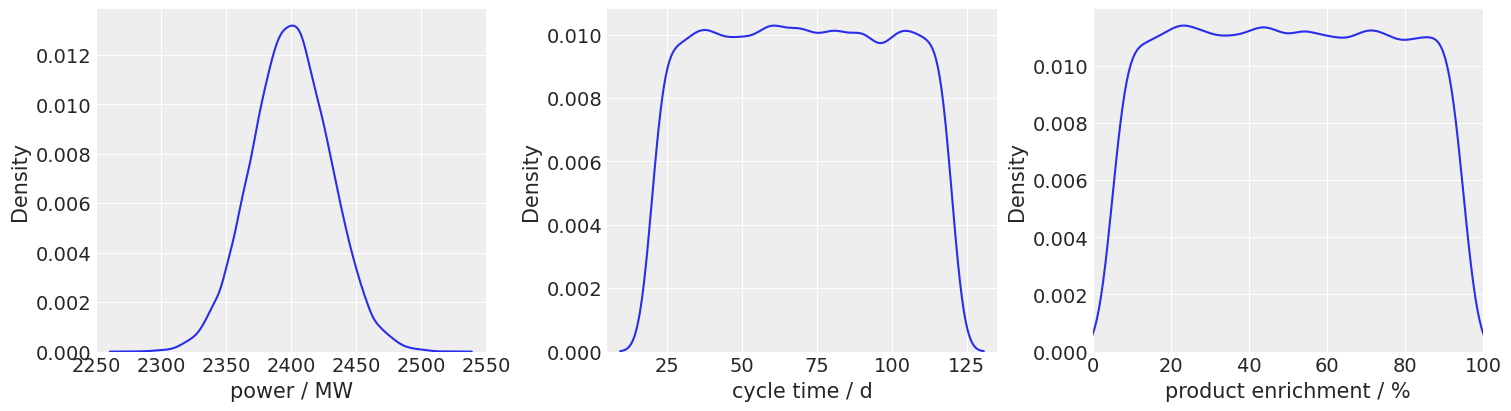

In [461]:
fig, axs = plt.subplots(1,3, figsize=(15, 4), squeeze=False)

for i, k in enumerate(powerlabels):
    ax = axs[i//3, i%3]
    sb.kdeplot(ax=ax, x=powersamples[powervars[i]])
    ax.set_xlabel(powerlabels[i])


axs[0,0].set_xlim(2250,2550)
axs[0,1].set_xlim(5, 135)
axs[0,2].set_xlim(0, 100)
fig.savefig("out/powermodel_prior.pdf")

## wrong prior

In [68]:
rvsUni = {
    "cycle_time": [20, 120],
    "slight_enrichment_grade": [1.0, 2.0],
    "high_enrichment_grade": [5, 95],
    "separation_efficiency_upu": [0.85, 0.99]
}
rvsPower = {
    "cycle_time": [20, 120],
    "high_enrichment_grade": [5, 95],

    "power": {"type": "Normal", "mu": 2400, "sigma": 30}
}
rvsNormal = {
    "cycle_time": {"type": "Normal", "mu": 50, "sigma": 10},
    "high_enrichment_grade": {"type": "TruncatedNormal", "mu": 85, "sigma": 10, "lower": 50, "upper": 94.9},
    "slight_enrichment_grade": {"type": "TruncatedNormal", "mu": 1.3, "sigma": 0.3, "lower": 0.8, "upper": 2.0}
}


with pm.Model() as unimodel:
    for (n, v) in rvsUni.items():
        pm.Uniform(n, lower=v[0], upper=v[1])

with pm.Model() as normmodel:
    ct = pm.Normal("cycle_time", mu=50, sigma=10)
    heg = pm.TruncatedNormal("high_enrichment_grade", mu=85, sigma=10, lower=10, upper=94.9)
    seg = pm.TruncatedNormal("slight_enrichment_grade", mu=1.3, sigma=0.3, lower=0.8, upper=2.0)

with pm.Model() as wrongunimodel:
    ct = pm.Uniform("cycle_time", lower=20, upper=120)
    heg = pm.Uniform("high_enrichment_grade", lower=5, upper=85)
    
    
with pm.Model() as powermodel:
    ct = pm.Uniform("cycle_time", lower=20, upper=120)
    heg = pm.Uniform("high_enrichment_grade", lower=5, upper=95)
    power = pm.Normal("power", mu=2400, sigma=30)

#samples = pm.sample_posterior_predictive(normmodel, samples=10000, model=unimodel, var_names=rvsUni.keys())
priorsamples = pm.sample_prior_predictive(35000, normmodel)
az.to_netcdf(priorsamples, "data/merged_10000.cdf")

priorsamples = pm.sample_prior_predictive(35000, wrongunimodel)
az.to_netcdf(priorsamples, "data/merged_10001.cdf")

'data/merged_10001.cdf'

Lower 5%:  25.102246410193786 Upper 95%:  115.03324268239037
Lower 5%:  8.968411441517196 Upper 95%:  81.04481076285991


(<Figure size 1000x400 with 2 Axes>,
 array([[<AxesSubplot:xlabel='cycle_time', ylabel='Density'>,
         <AxesSubplot:xlabel='high_enrichment_grade', ylabel='Density'>]],
       dtype=object))

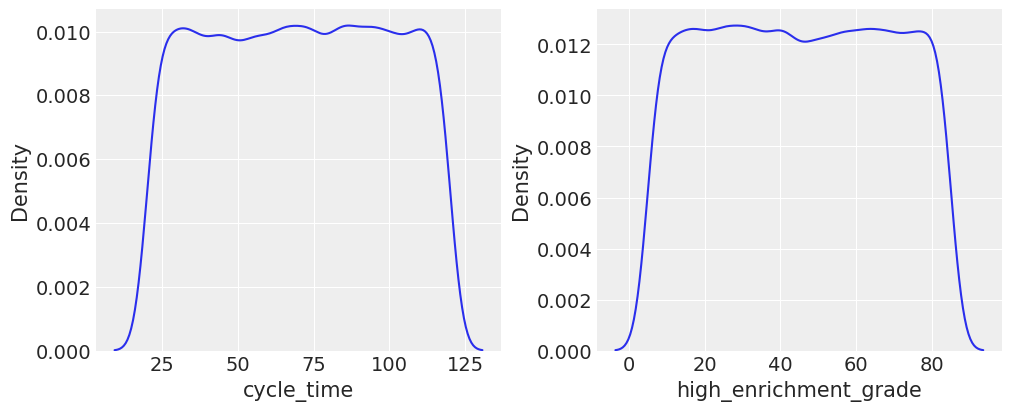

In [69]:
individual_densities(10001, cyclerichment_names)

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  60.027777799504264 Upper 95%:  61.356892211262135
Lower 5%:  78.86181315613067 Upper 95%:  84.87468628586575
Lower 5%:  25.102246410193786 Upper 95%:  115.03324268239037
Lower 5%:  8.968411441517196 Upper 95%:  81.04481076285991


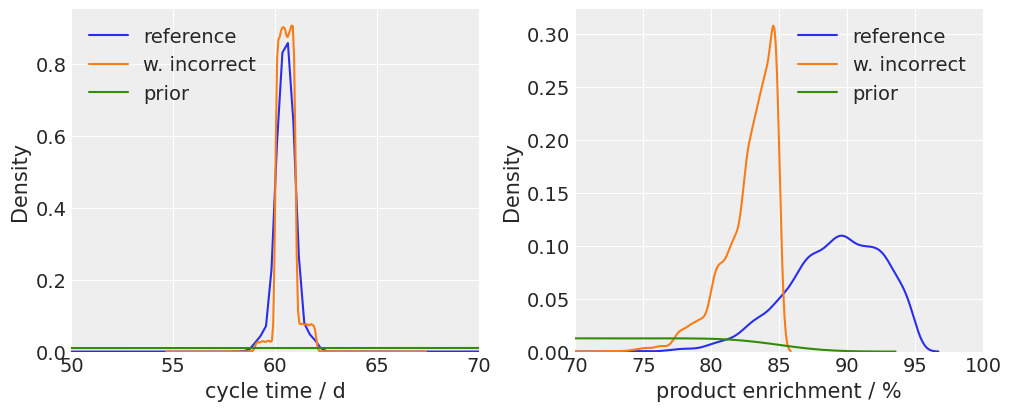

In [70]:
wrongpriorjob = 22753811
fa = individual_densities(22629172, cyclerichment_names, cyclerichment_labels, name='reference', figsize=(10,4), xlim=[(50, 70), (70, 100)])
individual_densities(wrongpriorjob, cyclerichment_names, cyclerichment_labels, name='w. incorrect', figaxs=fa)
individual_densities(10001, cyclerichment_names, cyclerichment_labels, name='prior', figaxs=fa)[0].savefig("out/cyclerichment_wrongprior_densities.png")

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  33.619440646731626 Upper 95%:  66.49857761949553
Lower 5%:  0.9079840917478644 Upper 95%:  1.7740307101993287
Lower 5%:  67.64957428966075 Upper 95%:  93.27734808815049


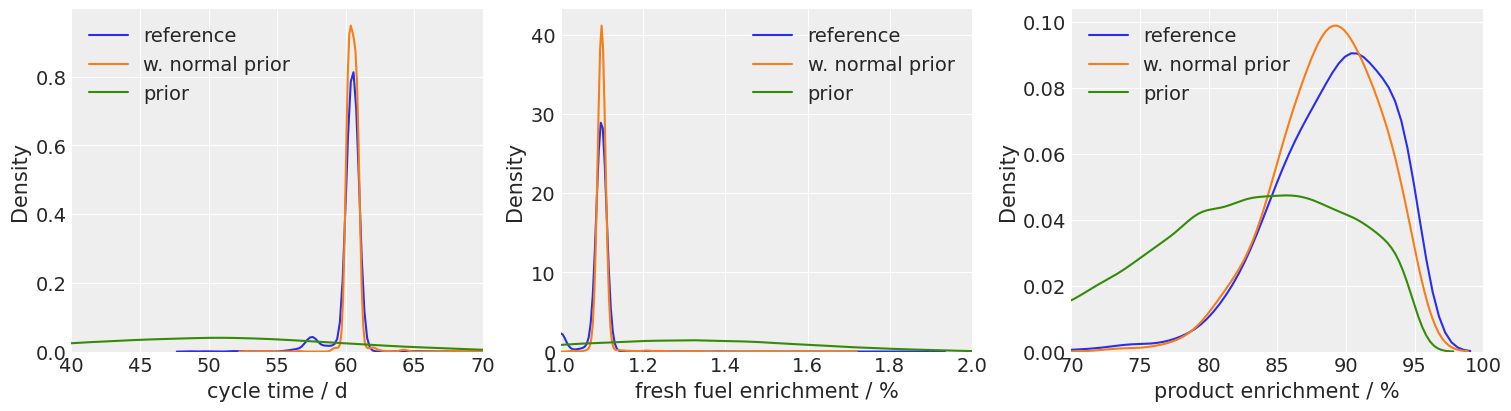

In [71]:
wrongpriorjob = 22711644
fa = individual_densities(22711474, cyclerichmentffe_names, cyclerichmentffe_labels, name='reference', xlim=[(40, 70), (1,2), (70, 100)])
individual_densities(wrongpriorjob, cyclerichmentffe_names, cyclerichmentffe_labels, name='w. normal prior', figaxs=fa)
individual_densities(10000, cyclerichmentffe_names, cyclerichmentffe_labels, name='prior', figaxs=fa)[0].savefig("out/cyclerichmentffe_wrongprior_densities.png")

## jitter added

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  58.91618879330317 Upper 95%:  60.97686527645906
Lower 5%:  1.0102929297052328 Upper 95%:  1.1035378915862648
Lower 5%:  67.8957608152749 Upper 95%:  93.57870844827528
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


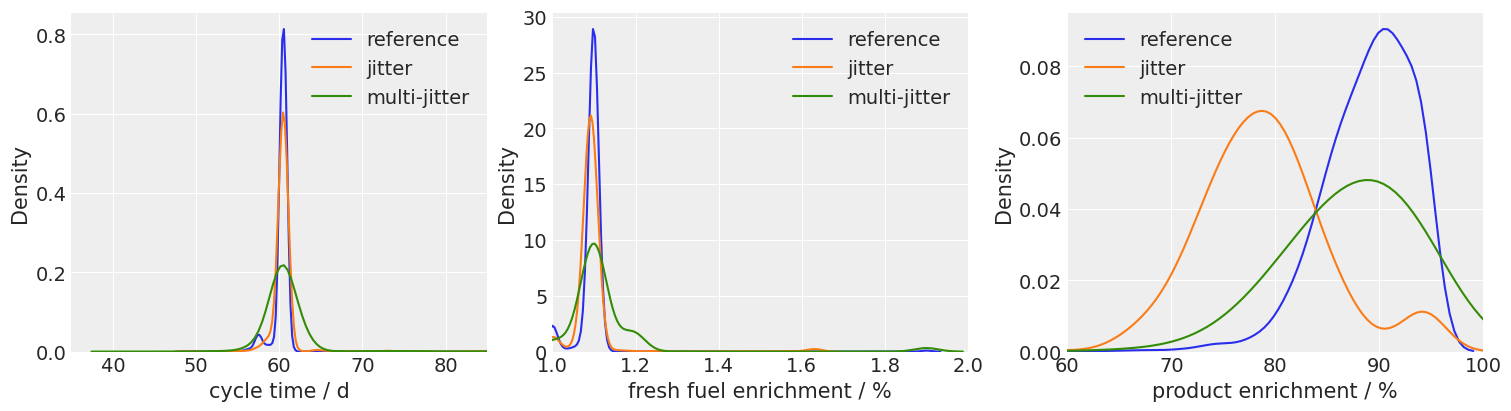

In [495]:
jitterjobs = [22711474, 22723444, 22723222]
names = ["reference", "jitter", "multi-jitter"]

fa = None
for (i,j) in enumerate(jitterjobs):
    fa = individual_densities(
        j,  cyclerichmentffe_names, cyclerichmentffe_labels, name=names[i], xlim=[(35, 85), (1,2), (60, 100)], figaxs=fa)
fa[0].savefig(f'out/cyclerichmentffe_jitter_22711474.pdf')

In [75]:
# jitter visualization

colors = ['red', 'black', 'blue']
xs = [0, 1]
true_values = [1,2]
jitter_values = [(np.random.randn()/4)+v for v in true_values]
multijitter_values = [(np.random.randn(10)/4)+v for v in true_values]

fig = plt.figure(figsize=(5,len(true_values)*5/4))
ax = fig.add_subplot(111)
ax.set_ylabel('ground truth value')
ax.set_yticks(true_values)
ax.set_xticks([1/4, 3/4])
ax.set_xticklabels(['jitter', 'multi-jitter'])

for i, v in enumerate(true_values):
    ax.plot(xs, [v, v], label=f'ground truth value {v}', color=colors[i])
    ax.scatter(1/4, jitter_values[i], color=colors[i])
    ax.scatter(np.full(multijitter_values[i].shape, 3/4), multijitter_values[i], marker='.', color=colors[i])

fig.savefig('out/jitterdemo.svg')

## different sigmas

In [224]:
dfs = [prepare_df(i) for i in [22629172, 22629203, 22629210]]
colors = [tuple(x) for x in plt.get_cmap('viridis')([float(i)/(len(dfs)-1) for (i, _) in enumerate(dfs)])]
labels = ["1%", "2%", "4%"]

df = prepare_df(22629172)
fig = plt.figure(figsize=(7,5))
ax = fig.subplots(1,1)
lines = [sb.kdeplot(ax=ax, data=df, x='cycle_time', y='high_enrichment_grade', fill=True, alpha=.8, label=labels[i], legend=True) for (i, df) in reversed(list(enumerate(dfs)))]

ax.set_xlim(50,70)
ax.set_ylim(50,100)
ax.legend()
ax.set_ylabel('product enrichment / %')
ax.set_xlabel('cycle time / d')
fig.savefig("out/cyclerichment_sigma_comparison.pdf")

In [249]:
fig = plt.Figure(figsize=(8, 8))

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.00

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

ax = fig.add_axes(rect_scatter)
ax_hx = fig.add_axes(rect_histx, sharex=ax)
ax_hy = fig.add_axes(rect_histy, sharey=ax)

ax.set_xlabel('cycle time / d')
ax.set_ylabel('product enrichment / %')
ax.set_xlim(50, 70)
ax.set_ylim(40, 100)
ax.set_xticks(np.arange(55, 70, 5))
ax.set_yticks(np.arange(45, 100, 5))
ax_hx.set_yticks([0.2, 0.4, 0.6, 0.8])
ax_hy.set_xticks([0.04, 0.08])
ax_hx.tick_params(axis='x', labelbottom=False)
ax_hy.tick_params(axis='y', labelleft=False)

n_max = 200

dfs = [prepare_df(i) for i in [22629172, 22629203, 22629210]]
labels = ["1%", "2%", "4%"]

for i, df in enumerate(reversed(dfs)):
    #ax.plot(p, e, linestyle='solid', alpha=1/2, label=f'chain #{int(chain)+1}')
    #ax_hx.hist(p, histtype='step', bins=20)
    #ax_hy.hist(e, histtype='step', bins=20, orientation='horizontal')
    sb.kdeplot(ax=ax, data=df, x='cycle_time', y='high_enrichment_grade', label=names[i], fill=True, alpha=.8, legend=True)
    sb.kdeplot(ax=ax_hx, data=df, x='cycle_time')
    sb.kdeplot(ax=ax_hy, data=df, y='high_enrichment_grade')
ax.legend()
fig.savefig('out/cyclerichment_sigmas_marginal.pdf')

<ipython-input-249-5a07c2e1f2aa>:41: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig('out/cyclerichment_sigmas_marginal.pdf')


In [452]:
# comparison of different likelihood sources

measuresource_cmpjobs = [22629172, 22629203, 22629210]
names = ["1%", "2%", "4%"]
fa = None

for (i, j) in enumerate(measuresource_cmpjobs):
    fa = individual_densities(j,
                              cyclerichment_names,
                              cyclerichment_labels,
                              [(50, 90),  (50, 100)],
                              name=names[i], figaxs=fa)
fa[0].savefig('out/cyclerichment_sigma_comparison_1d.pdf')

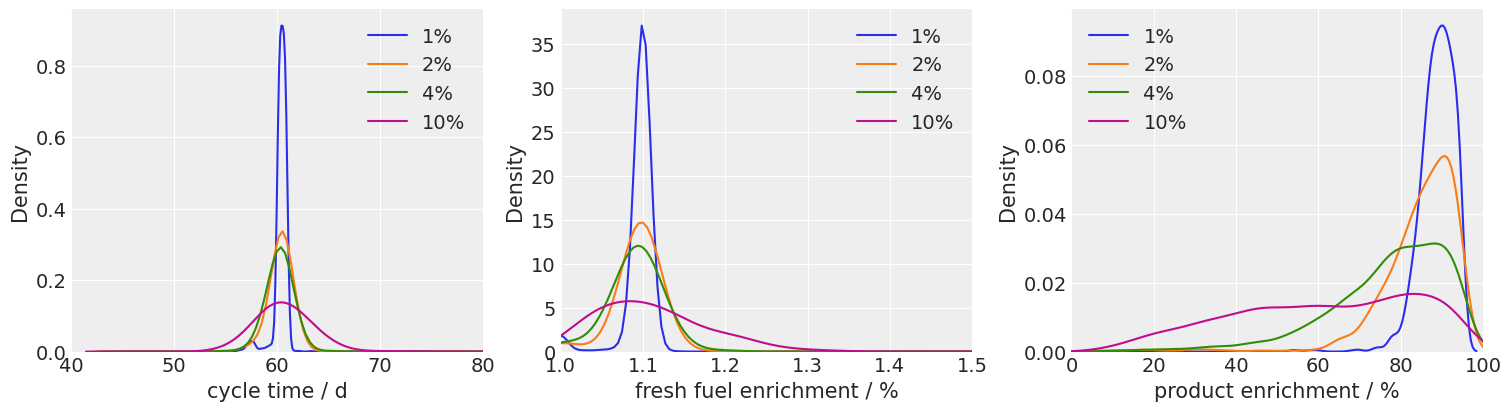

In [453]:
# comparison of different sigmas

cmpjobs = [22663725, 22723358, 22723376, 22723393]
labels = ["1%", "2%", "4%", "10%"]
fa = None
for (i, j) in enumerate(cmpjobs):
    fa = individual_densities(j, ["cycle_time", "slight_enrichment_grade", "high_enrichment_grade"], ["cycle time / d", "fresh fuel enrichment / %", "product enrichment / %"], [(40, 80), (1, 1.5), (0, 100)], name=labels[i], figaxs=fa)
fa[0].savefig("out/cyclerichmentffe_sigma_comparison.pdf")

## different target values

Lower 5%:  60.04664595846298 Upper 95%:  60.95225435891543
Lower 5%:  76.58916773199248 Upper 95%:  84.15339820125737
Lower 5%:  40.031578688313346 Upper 95%:  40.95506398963294
Lower 5%:  88.13497534449334 Upper 95%:  94.38439165872204
Lower 5%:  80.03487068053361 Upper 95%:  80.9524829089896
Lower 5%:  81.20414370846481 Upper 95%:  88.53265169125255


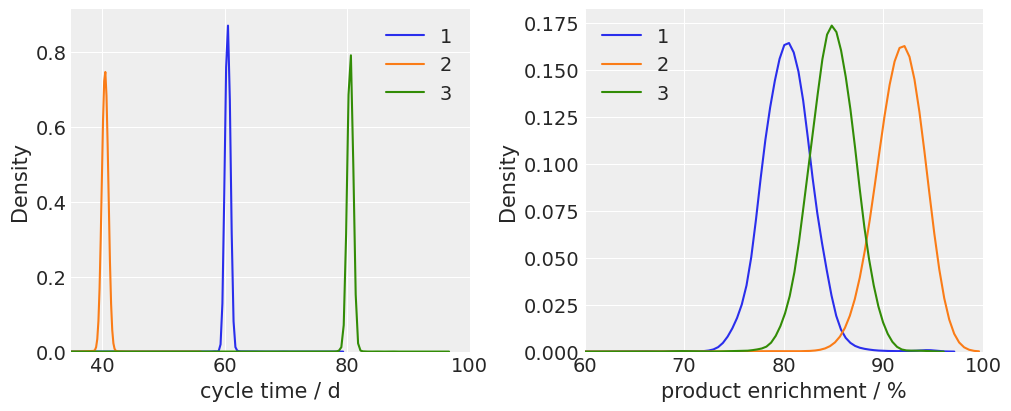

In [493]:
# comparison of different target parameters

cmpjobs = [22532567, 22532779, 22533115]
fa = None
for i, j in enumerate(cmpjobs):
    fa = individual_densities(j, cyclerichment_names, cyclerichment_labels, xlim=[(35, 100), (60, 100)], figaxs=fa, name=f'{i+1}')
fa[0].savefig(f'out/cyclerichment_targetcmp.pdf')

## different likelihood sources

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


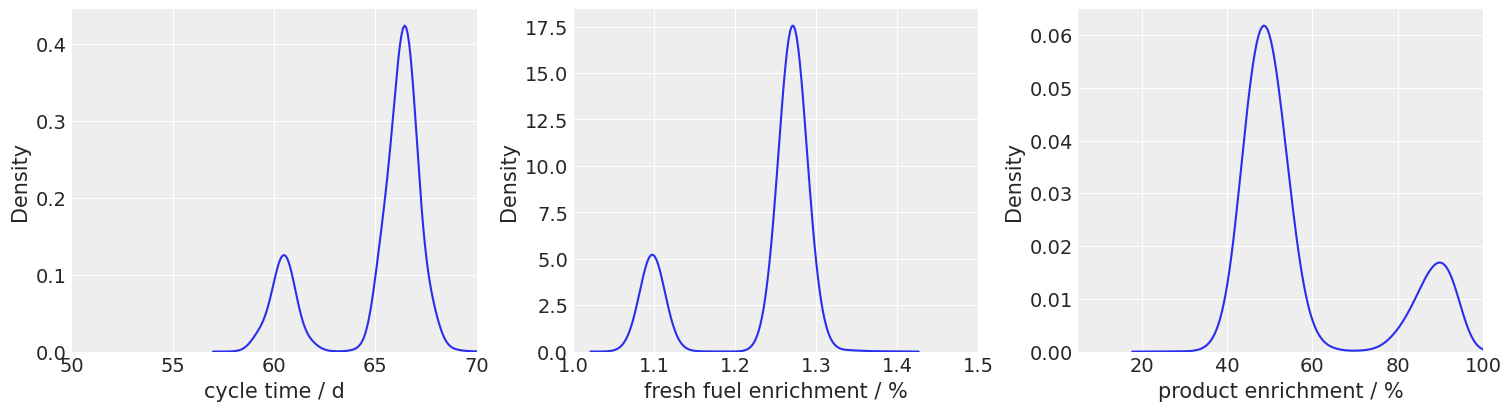

In [27]:
multipeakjob = 22824761
individual_densities(multipeakjob,  cyclerichmentffe_names, cyclerichmentffe_labels, xlim=[(50, 70), (1,1.5), (5, 100)])[0].savefig(f'out/cyclerichmentffe_multipeak_{multipeakjob}.pdf')

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


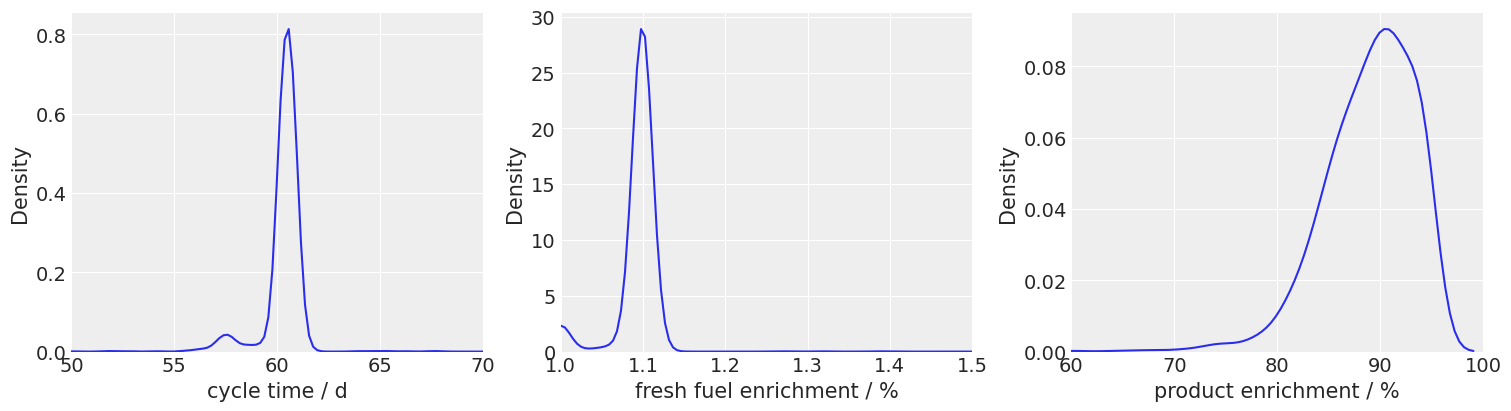

In [19]:
singlepeakjob = 22711474
individual_densities(singlepeakjob,  cyclerichmentffe_names, cyclerichmentffe_labels, xlim=[(50,70), (1, 1.5), (60, 100)])[0].savefig(f'out/cyclerichmentffe_{singlepeakjob}.svg')

Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan
Lower 5%:  nan Upper 95%:  nan


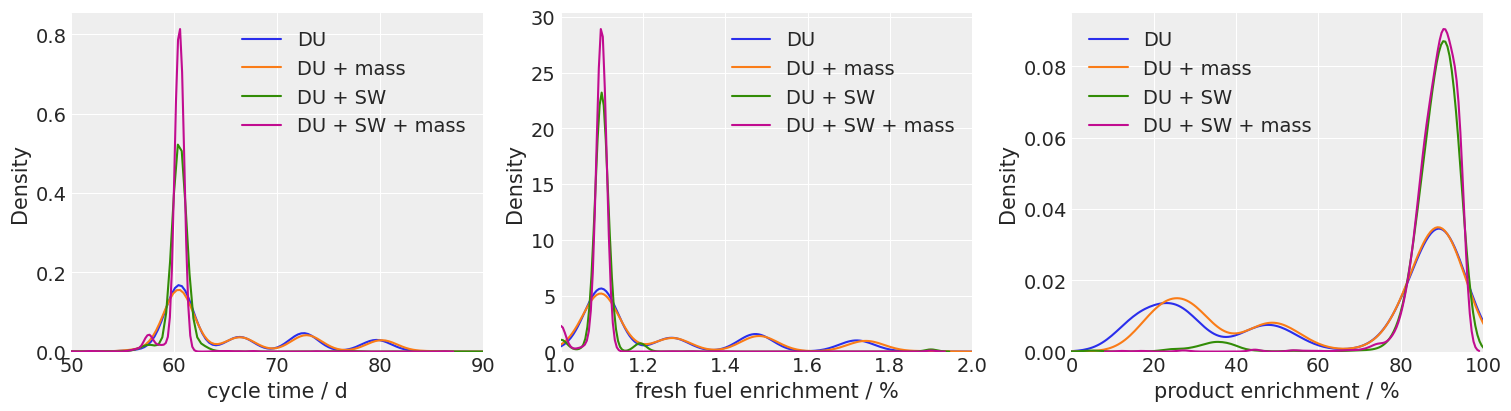

In [14]:
# comparison of different likelihood sources

measuresource_cmpjobs = [22719887, 22711417, 22719870, 22711474]
names = ['DU', 'DU + mass', 'DU + SW', 'DU + SW + mass']
fa = None

for (i, j) in enumerate(measuresource_cmpjobs):
    fa = individual_densities(j,
                              cyclerichmentffe_names,
                              cyclerichmentffe_labels,
                              [(50, 90), (1, 2), (0, 100)],
                              name=names[i], figaxs=fa)
fa[0].savefig('out/cyclerichment_ffe_sources_comparison.pdf')

<ipython-input-18-4f8412ca01d6>:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plot_chains(readcdf(f'data/merged_{newbadjob}.cdf'), ixs=[0,5], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, legends=('mode 1','mode 2'), xlims=[(50, 70), (1,1.5), (5, 100)]


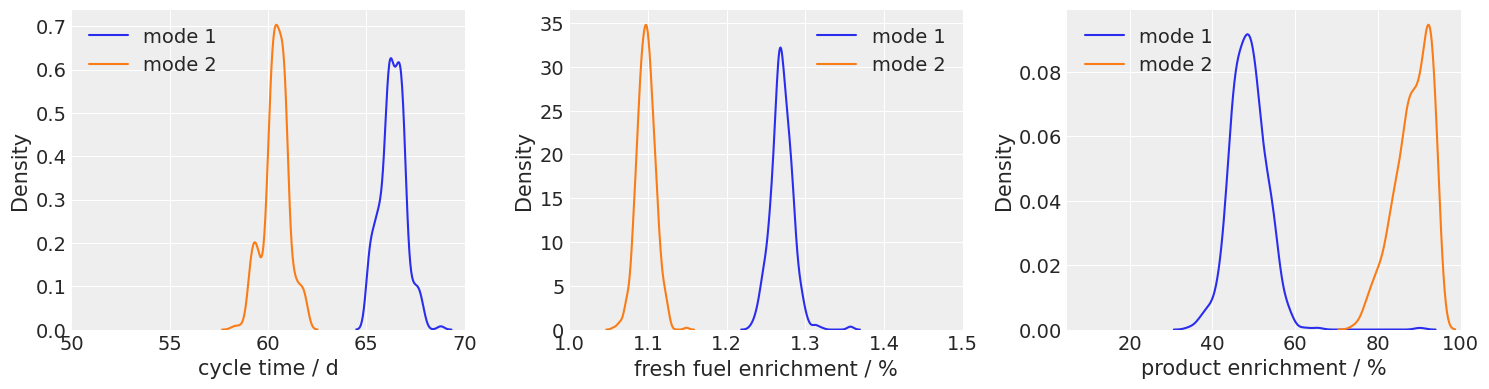

In [18]:
newbadjob = 22824761
plot_chains(readcdf(f'data/merged_{newbadjob}.cdf'), ixs=[0,5], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, legends=('mode 1','mode 2'), xlims=[(50, 70), (1,1.5), (5, 100)]
           ).savefig(f'out/cyclerichmentffe_{newbadjob}_chains.svg')

/home/lbo/.anaconda3/envs/fcjupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.tight_layout(*args, **kwargs)


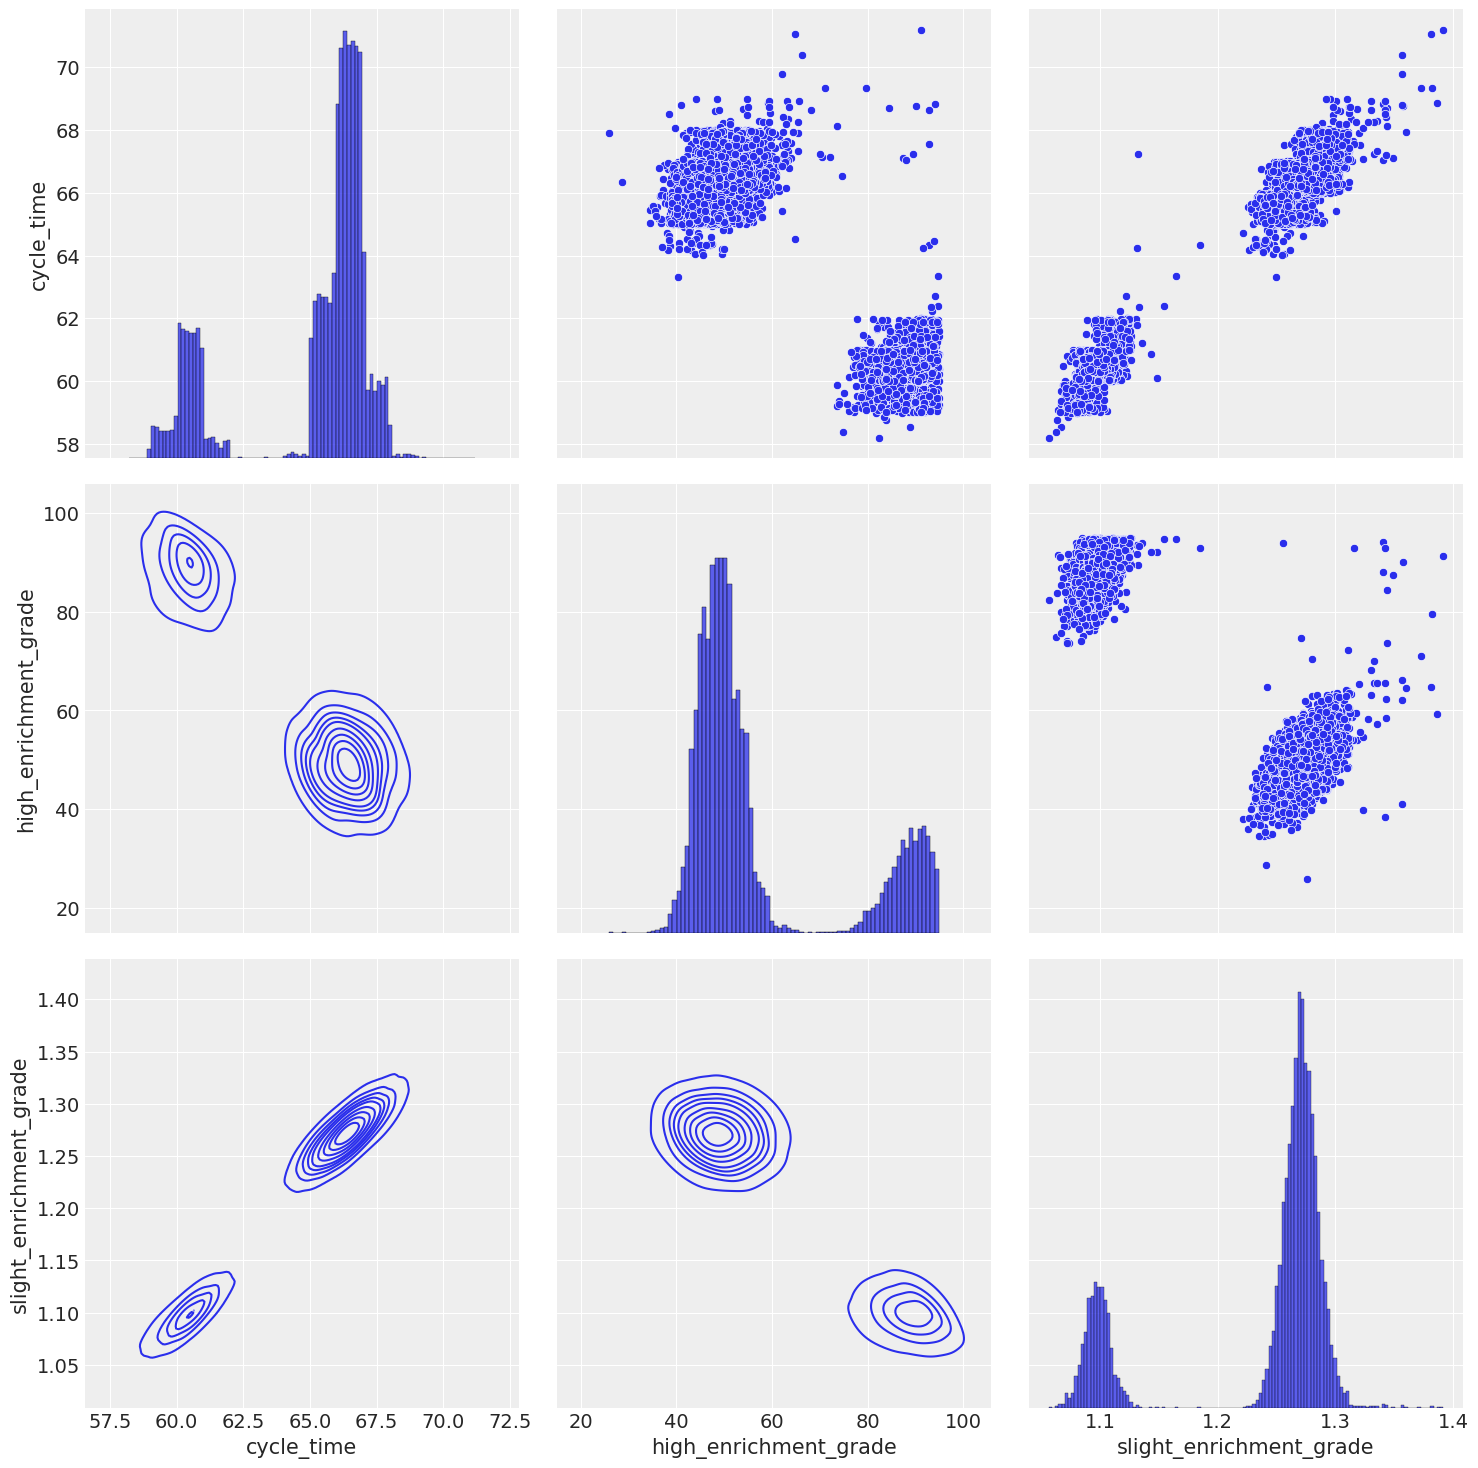

In [542]:
plot_all_histograms(22824761)

<ipython-input-29-c9e552565e0a>:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plot_chains(readcdf(f'data/merged_{newgoodjob}.cdf'), ixs=[0,5], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, xlims=[(50, 70), (1,1.5), (5, 100)]


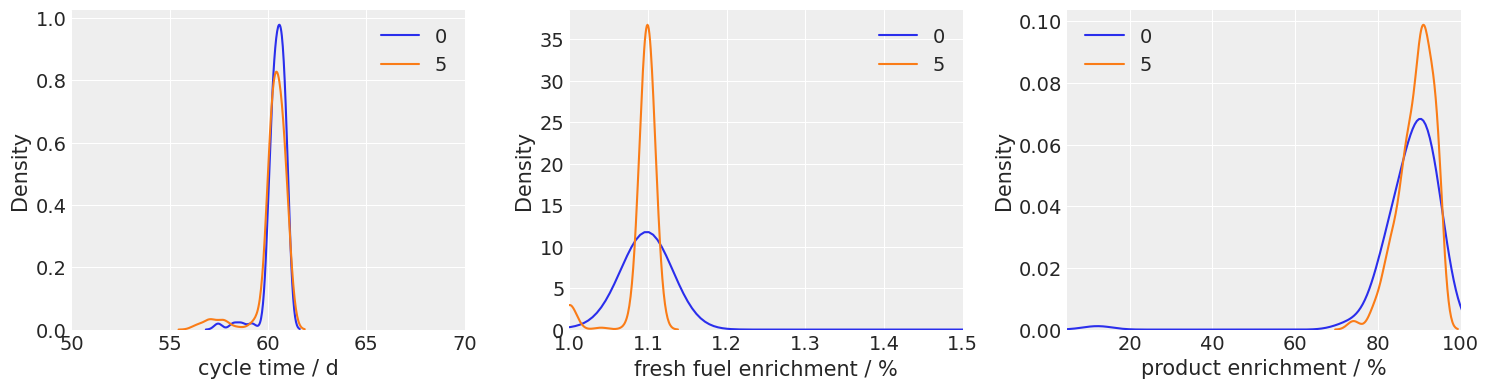

In [29]:
newgoodjob = 22711474
plot_chains(readcdf(f'data/merged_{newgoodjob}.cdf'), ixs=[0,5], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, xlims=[(50, 70), (1,1.5), (5, 100)]
           ).savefig(f'out/cyclerichmentffe_{newgoodjob}_chains.pdf')

<ipython-input-13-f15b90236432>:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plot_chains(readcdf(f'data/merged_{j}.cdf'), ixs=[0,1,2,3], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, xlims=[(50, 90), (1,2), (5, 100)]
<ipython-input-13-f15b90236432>:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plot_chains(readcdf(f'data/merged_{j}.cdf'), ixs=[0,1,2,3], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, xlims=[(50, 90), (1,2), (5, 100)]
<ipython-input-13-f15b90236432>:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plot_chains(readcdf(f'data/merged_{j}.cdf'), ixs=[0,1,2,3], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, xl

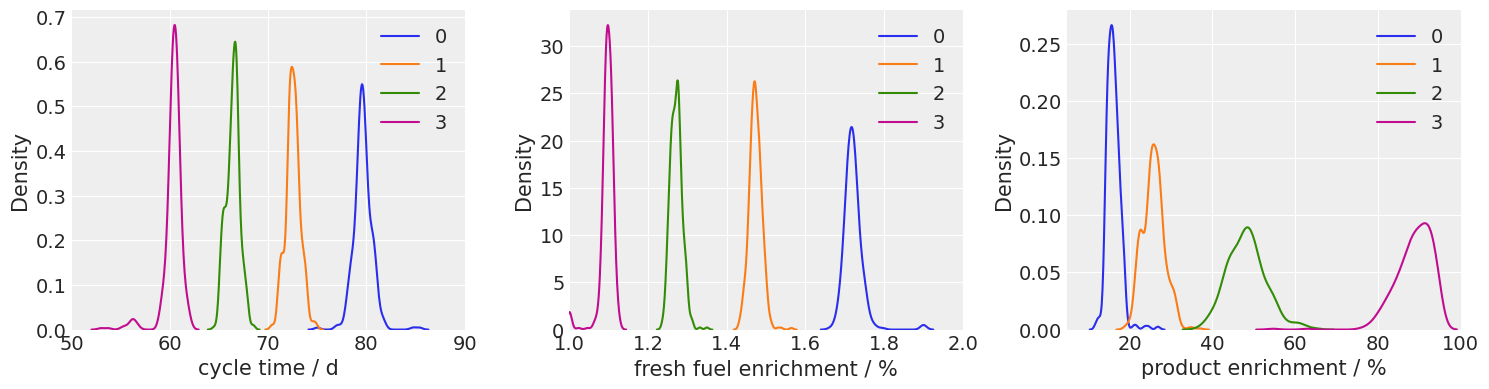

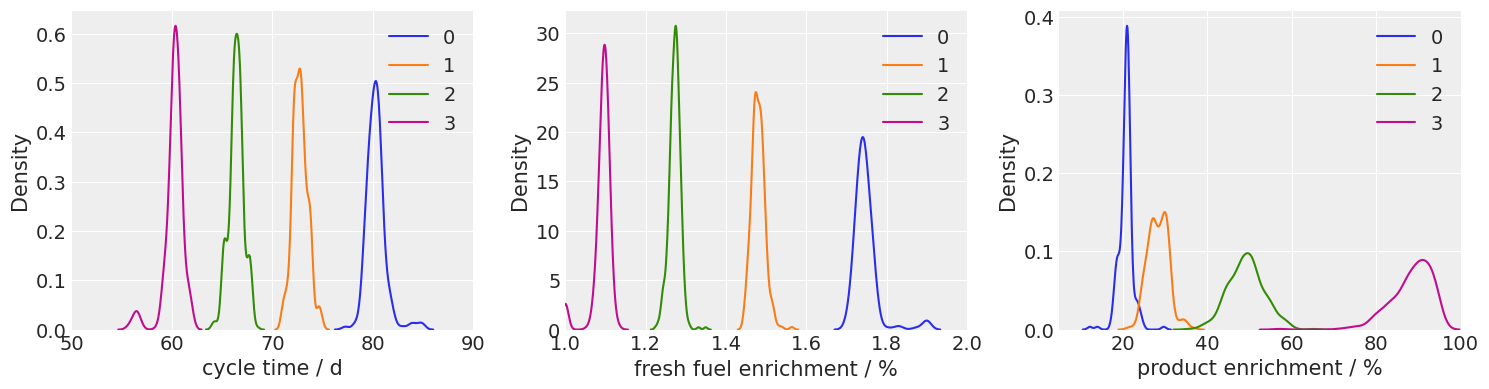

In [13]:
for j in measuresource_cmpjobs:
    plot_chains(readcdf(f'data/merged_{j}.cdf'), ixs=[0,1,2,3], vars=cyclerichmentffe_names, labels=cyclerichmentffe_labels, xlims=[(50, 90), (1,2), (5, 100)]
           ).savefig(f'out/cyclerichment_{j}_chains.pdf')

In [17]:
for jobid in [22824761]:
    plot_chain_hists(readcdf(f'data/merged_{jobid}.cdf')).savefig(f'out/allchains_draws_{jobid}.pdf')

Iteration: plot 0/0 of 45
Iteration: plot 0/1 of 45
Iteration: plot 0/2 of 45
Iteration: plot 1/0 of 45
Iteration: plot 1/1 of 45
Iteration: plot 1/2 of 45
Iteration: plot 2/0 of 45
Iteration: plot 2/1 of 45
Iteration: plot 2/2 of 45
Iteration: plot 3/0 of 45
Iteration: plot 3/1 of 45
Iteration: plot 3/2 of 45
Iteration: plot 4/0 of 45
Iteration: plot 4/1 of 45
Iteration: plot 4/2 of 45
Iteration: plot 5/0 of 45
Iteration: plot 5/1 of 45
Iteration: plot 5/2 of 45
Iteration: plot 6/0 of 45
Iteration: plot 6/1 of 45
Iteration: plot 6/2 of 45
Iteration: plot 7/0 of 45
Iteration: plot 7/1 of 45
Iteration: plot 7/2 of 45
Iteration: plot 8/0 of 45
Iteration: plot 8/1 of 45
Iteration: plot 8/2 of 45
Iteration: plot 9/0 of 45
Iteration: plot 9/1 of 45
Iteration: plot 9/2 of 45
Iteration: plot 10/0 of 45
Iteration: plot 10/1 of 45
Iteration: plot 10/2 of 45
Iteration: plot 11/0 of 45
Iteration: plot 11/1 of 45
Iteration: plot 11/2 of 45
Iteration: plot 12/0 of 45
Iteration: plot 12/1 of 45
Iter

<ipython-input-17-17d0053de65c>:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plot_chain_hists(readcdf(f'data/merged_{jobid}.cdf')).savefig(f'out/allchains_draws_{jobid}.pdf')
